In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

In [2]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [4]:
from scipy.io import arff
data = arff.loadarff('data (1)/3year.arff')
df = pd.DataFrame(data[0])

In [5]:
df=df.rename({"class":"bankrupt"},axis = 1 )


In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["bankrupt"] = le.fit_transform(df.bankrupt)

In [7]:
def correlation(dataset, threshold):
    col_corr = list() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.append(colname)
    return col_corr   
col_corr=correlation(df,.9)

In [8]:
df = df.drop(columns=col_corr)
df.shape

(10503, 41)

## function to get red of outliers

In [9]:
def find_outliers_IQR(df):

    q1=df.quantile(0.1)

    q3=df.quantile(0.9)

    IQR=q3-q1

    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

    return outliers

In [10]:
for i in df.columns.to_list()[:-1]:
    
    index = find_outliers_IQR(df[i]).index
    df.drop(index,axis=0,inplace=True)
print (df.shape )   
    
   
    

(4624, 41)


In [11]:
df=df.fillna(df.median())

In [12]:
target = "bankrupt"
X = df.drop(columns=target)
y = df[target]

In [13]:
y.value_counts()

0    4449
1     175
Name: bankrupt, dtype: int64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)

In [15]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
print(X_train_over.shape)
X_train_over.head()

(7116, 40)


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr8,Attr9,Attr12,Attr13,Attr15,...,Attr48,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr63,Attr64
0,0.019376,0.85181,-0.20258,0.76048,-98.7640,0.17397,1.0157,0.022910,0.029819,4317.50,...,-0.013997,-3920.70,0.015492,0.130750,0.98451,0.04096,5.6620,15.6790,2.8554,6.7676
1,0.143140,0.31195,0.37164,2.60500,21.8510,2.08940,1.0981,0.777450,0.097571,509.87,...,0.159200,13944.00,0.089315,0.219610,0.91069,0.12334,9.2913,6.9047,9.8842,5.7679
2,0.004972,0.74115,0.25516,1.47130,-28.0330,0.34926,1.6310,0.077705,0.045935,3610.80,...,-0.009451,491.03,0.001841,0.019206,0.97521,0.77154,7.1257,4.0232,3.0124,8.0187
3,0.107390,0.85405,-0.25684,0.63011,-189.7100,0.17090,1.2201,0.187810,0.145600,1754.70,...,0.152660,-19476.00,0.162490,0.735760,0.89330,1.06880,4.8989,7.0698,1.7571,2.1692
4,-0.045354,0.66269,0.18720,1.37250,-7.5979,0.50899,4.5079,-0.090243,0.008930,6008.80,...,-0.118160,771.59,-0.010966,-0.134460,1.00990,0.23016,16.9340,17.5280,8.9696,14.5310


In [16]:
scaler = MinMaxScaler()

In [17]:
X_train_over=scaler.fit_transform(X_train_over)

In [18]:

X_test_over = scaler.transform(X_test)

## building the model

In [19]:
model = Sequential()
model.add(Dense(units=1500,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1000,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=500,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=50,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1,activation='sigmoid'))



In [20]:
model.compile(loss='binary_crossentropy', optimizer='adam')

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

In [22]:
model.fit(x=X_train_over, 
          y=y_train_over, 
          epochs=200,
          validation_data=(X_test_over, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/200
223/223 [==============================] - 20s 58ms/step - loss: 0.6511 - val_loss: 0.4267
Epoch 2/200
223/223 [==============================] - 12s 53ms/step - loss: 0.6124 - val_loss: 0.4850
Epoch 3/200
223/223 [==============================] - 11s 51ms/step - loss: 0.5989 - val_loss: 0.5011
Epoch 4/200
223/223 [==============================] - 11s 51ms/step - loss: 0.5965 - val_loss: 0.6684
Epoch 5/200
223/223 [==============================] - 12s 53ms/step - loss: 0.5795 - val_loss: 0.4123
Epoch 6/200
223/223 [==============================] - 11s 49ms/step - loss: 0.5712 - val_loss: 0.6983
Epoch 7/200
223/223 [==============================] - 13s 59ms/step - loss: 0.5691 - val_loss: 0.5760
Epoch 8/200
223/223 [==============================] - 12s 56ms/step - loss: 0.5644 - val_loss: 0.4893
Epoch 9/200
223/223 [==============================] - 14s 62ms/step - loss: 0.5533 - val_loss: 0.5758
Epoch 10/200
223/223 [==============================] - 13s 60ms/step - l

<AxesSubplot:>

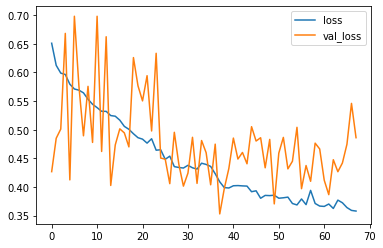

In [23]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [24]:
predictions = (model.predict(X_test) > 0.5).astype("int32")


29/29 [==============================] - 2s 10ms/step


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       891
           1       0.10      0.03      0.05        34

    accuracy                           0.95       925
   macro avg       0.53      0.51      0.51       925
weighted avg       0.93      0.95      0.94       925



In [26]:
test_data = arff.loadarff('data (1)/2year.arff')
test_df = pd.DataFrame(test_data[0])

In [27]:
test_df.shape

(10173, 65)

In [28]:
test_df=test_df.rename({"class":"bankrupt"},axis = 1 )

In [29]:
test_df["bankrupt"] = le.fit_transform(test_df.bankrupt)

In [30]:
test_df = test_df.drop(columns=col_corr)
test_df.shape


(10173, 41)

In [31]:
test_df=test_df.dropna()

In [32]:
test_df

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr8,Attr9,Attr12,Attr13,Attr15,...,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr63,Attr64,bankrupt
0,0.202350,0.46500,0.240380,1.51710,-14.547,0.918160,1.1519,0.545610,0.178650,603.20,...,242500.0000,0.131840,0.473950,0.86816,0.000240,8.5487,5.1655,3.3879,5.34400,0
5,0.287840,0.55225,0.316340,1.70330,38.803,0.807610,1.2920,0.639910,0.199180,683.17,...,8040.8000,0.225990,0.645370,0.77401,0.229690,7.8151,3.1534,3.2933,6.33460,0
9,0.009901,0.71174,0.065186,1.14850,-62.297,0.405000,1.1738,0.030651,0.047467,4662.40,...,1.1485,0.203090,0.034347,0.83056,0.720470,7.7605,4.1253,2.6732,2.36800,0
13,0.179490,0.42473,0.552350,2.45160,42.408,1.354400,1.1023,0.588520,0.094009,638.02,...,5133.0000,0.092802,0.312010,0.90720,0.076880,9.3788,4.9068,6.7927,38.49200,0
14,0.124600,0.20223,0.169850,3.15630,92.043,3.944800,1.2747,1.877800,0.283050,470.07,...,15157.0000,0.215480,0.156190,0.78452,0.154760,9.7697,3.1420,7.0431,0.73834,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10144,0.017809,0.68783,-0.120540,0.59797,-19.153,0.453740,3.0423,0.063407,0.028503,2895.30,...,-1502.0000,0.004722,0.057064,0.98606,0.271790,82.3330,23.7980,10.1470,3.70720,1
10147,0.030497,0.58615,-0.154100,0.71603,-64.241,0.706060,1.8680,0.076571,0.081292,1408.90,...,-2026.6000,0.037036,0.073691,0.98061,0.047546,14.7900,7.9381,3.4422,3.05500,1
10164,0.021711,0.67433,-0.053895,0.86170,-28.020,0.482940,2.2549,0.055610,0.026651,4095.70,...,-3597.8000,0.028367,0.066667,0.99448,0.734480,20.6960,10.3900,5.7863,3.39490,1
10166,0.050322,0.77767,-0.183350,0.65177,-34.598,0.285890,3.5422,0.095577,0.035115,2282.10,...,-3669.0000,0.033535,0.226340,0.97348,0.645760,25.9930,18.8420,6.7276,5.39270,1


In [33]:
target = "bankrupt"
final_x_test = test_df.drop(columns=target)
final_y_test = test_df[target]

In [34]:
final_y_test

0        0
5        0
9        0
13       0
14       0
        ..
10144    1
10147    1
10164    1
10166    1
10172    1
Name: bankrupt, Length: 4088, dtype: int32

In [35]:
predictions = (model.predict(final_x_test) > 0.8).astype("int32")

128/128 [==============================] - 2s 13ms/step


In [36]:
for i in predictions:
    if i ==1:
        print(i)
   
    

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [37]:
print(classification_report(final_y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      4015
           1       0.03      0.05      0.04        73

    accuracy                           0.95      4088
   macro avg       0.51      0.51      0.51      4088
weighted avg       0.97      0.95      0.96      4088



###  although the accuracy is high but the neural network model is not very good in terms of recall metric